<h1><center>Лабораторна робота 3.</center></h1>
<h2><center>Задача класифікації за набором даних Adult репозитарію UCI</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="3"></a>

## Зміст

1. [Синтетичний набір даних "дівчина в барі"](#3.1)
2. [Функції для обрахування ентропії й приросту інформації](#3.2)
3. [Задача класифікації за набором данних "Adult"](#3.3)
    - [Дерево рішень без налаштування параметрів ](#3.3.1)
    - [Дерево рішень з налаштуванням параметрів](#3.3.2)

У цій лабораторній роботі Вам пропонується розібратися з тим, як працює дерево рішень на іграшковому прикладі. Ми навчимо і налаштуємо дерево рішень і (за бажанням) випадковий ліс для задачі класифікації за уже знайомим набором даних Adult сховища UCI.

Спершу підключаємо необхідні бібліотеки:

In [1]:
# Відключимо різні попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5
plt.gcf().set_dpi(100)

<Figure size 700x500 with 0 Axes>

<a class="anchor" id="3.1"></a>

## <span style="color:blue; font-size:1.2em;">3.1. Синтетичний набір даних "дівчина в барі"</span>

[Повернутися до змісту](#3)

Мета цієї частини - "на пальцях", за допомогою іграшкової задачі класифікації розібратися в тому, як працюють дерева рішень. Саме по собі дерево рішень є доволі слабким алгоритмом, але основані на ньому алгоритми випадкового лісу і градієнтного бустингу - мабуть, найкращі рішення, що є на сьогодні (в задачах, де можна обійтися без нейронних мереж). Тому розібратися в тому, як працює дерево рішень, доволі корисно.

Спершу розглянемо таку задачу бінарної класифікації: чи поїде з Вами дівчина з бару випити філіжанку кави? Результат цієї задачі залежатиме від таких чинників: Ваша зовнішність і внутрішня харизма, міцність запропонованих напоїв і, як би це не звучало меркантильно, від кількості витрачених в барі грошей.

### Створення набору даних

In [3]:
# Створення датафрейму з dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Зовнішність', 'Алкоголь_в_напої',
            'Рівень_харизми', 'Витрачені_гроші']

Задамо навчальну вибірку:

In [5]:
df_train = {'Зовнішність': ['приємна', 'приємна', 'приємна', 'відштовхуюча',
                            'відштовхуюча', 'відштовхуюча', 'приємна'],
            'Алкоголь_в_напої': ['так', 'так', 'ні', 'ні', 'так', 'так', 'так'],
            'Рівень_харизми': ['високий', 'низький', 'середній', 'середній', 'низький',
                               'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато', 'мало', 'багато',
                                                                           'багато', 'багато'],
            'Поїде': LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])}

df_train = create_df(df_train, features)
df_train

,Поїде,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_низький,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,0,1,0,1,1,0,0,1,0
1,1,0,1,0,1,0,1,0,0,1
2,0,0,1,1,0,0,0,1,1,0
3,1,1,0,1,0,0,0,1,0,1
4,1,1,0,0,1,0,1,0,1,0
5,0,1,0,0,1,1,0,0,1,0
6,0,0,1,0,1,0,0,1,1,0


Задамо тестову вибірку:

In [6]:
df_test = {'Зовнішність': ['приємна', 'приємна', 'відштовхуюча'], 'Алкоголь_в_напої': ['ні', 'так', 'так'],
           'Рівень_харизми': ['середній', 'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато']}
df_test = create_df(df_test, features)
df_test

,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,1,1,0,0,1,1,0
1,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,1,0


In [7]:
# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
y = df_train['Поїде']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Витрачені_гроші_мало,Рівень_харизми_високий,Витрачені_гроші_багато,Зовнішність_відштовхуюча,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так
0,0,1,1,0,0,1,0,1
1,1,0,0,0,0,1,0,1
2,0,0,1,0,1,1,1,0
3,1,0,0,1,1,0,1,0
4,0,0,1,1,0,0,0,1
5,0,1,1,1,0,0,0,1
6,0,0,1,0,1,1,0,1


In [8]:
df_test

,Витрачені_гроші_мало,Рівень_харизми_високий,Витрачені_гроші_багато,Зовнішність_відштовхуюча,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так
0,0,0,1,0,1,1,1,0
1,1,1,0,0,0,1,0,1
2,0,0,1,1,1,0,0,1


Дайте відповідь на запитання нижче.

<span style="color:red; font-size:2em;">Завдання 1</span>

**Для всіх варіантів:**

Виконайте це завдання з допомогою програмного коду Python.

**Для варіантів 1-5:**

Обрахуйте ентропію початкової системи ($S_0$)? Під станами системи розуміємо значення ознаки "Поїде" - 0 або 1 (тобто всього 2 стани).

**Для варіантів 6-10:**

Яким є значення ентропії $S_1$ лівої групи, тих, в кого зовнішність приємна?

**Для варіантів 11-15:**

Яким є значення ентропії $S_2$ правої групи, тих, в кого зовнішність відштовхуюча?

**Для варіантів 16-20:**

Яким є приріст інформації за даного розбиття (IG)?

Побудуйте за допомогою `sklearn` дерево рішень, навчивши його на навчальній вибірці. Глибину можна не обмежувати.

In [9]:
# Ваш код тут


Додатково: відобразіть дерево за допомогою graphviz. Можна використати бібліотеку `pydotplus`.

In [10]:
# Ваш код тут


<a class="anchor" id="3.2"></a>

## <span style="color:blue; font-size:1.2em;">3.2. Функції для обрахування ентропії й приросту інформації</span>

[Повернутися до змісту](#3)

**Приклад для перевірки:** 9 синіх кульок і 11 жовтих. Нехай кулька перебуває в стані "1", якщо вона синя і "0", якщо – жовта.

In [11]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_1.png)

Далі нехай кульки розбиваються на 2 групи:

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_2.png)

In [12]:
# дві групи
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синіх і 5 жовтих
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синя і 6 жовтих

Реалізуйте функцію для обрахування ентропії Шеннона:

Перевіряємо працездатність функції `entropy`:

In [13]:
def entropy(a_list):
    
    # Ваш код тут
    
    pass

In [14]:
print(entropy(balls)) # 9 синіх і 11 жовтих
print(entropy(balls_left)) # 8 синіх і 5 жовтих
print(entropy(balls_right)) # 1 синя і 6 жовтих
print(entropy([1,2,3,4,5,6])) # ентропія гральної кості з незміщенним центром тяжіння

None
None
None
None


<span style="color:red; font-size:2em;">Завдання 2</span>

**Для всіх варіантів:**

Виконайте це завдання з допомогою програмного коду Python.

**Для варіантів 1-5:**

Чому дорівнює ентропія гральної кисті з незміщеним центром тяжіння?

**Для варіантів 6-10:**

Чому дорівнює ентропія стану, що задане початковим списком кульок `balls`?

**Для варіантів 11-15:**

Чому дорівнює ентропія стану, що задане списком `balls_left`?

**Для варіантів 16-20:**

Чому дорівнює ентропія стану, що задане списком `balls_right`?

In [15]:
# обрахунок приросту інформації

def information_gain(root, left, right):
    """ Root - початковий набір даних, left і right два розбиття початкового набору"""
    
    # Ваш код тут
    
    pass

<span style="color:red; font-size:2em;">Завдання 3</span>

**Для всіх варіантів**

Виконайте це завдання з допомогою програмного коду Python.

**Для варіантів 1-5:**

Який приріст інформації, якщо поділити вибірку на `balls_left` і `balls_right`?

**Для варіантів 6-10:**

Який приріст інформації, якщо поділити вибірку на `balls_left` і `balls_right`?

**Для варіантів 11-15:**

Який приріст інформації, якщо поділити вибірку на `balls_left` і `balls_right`?

**Для варіантів 16-20:**

Який приріст інформації, якщо поділити вибірку на `balls_left` і `balls_right`?


<a class="anchor" id="3.3"></a>

## <span style="color:blue; font-size:1.2em;">3.3. Задача класифікації за набором данних "Adult</span>

[Повернутися до змісту](#3)

**Набір даних [UCI Adult](http://archive.ics.uci.edu/ml/machine-learning-databases/adult)** (додатково завантажувати не треба, всі дані є в репозитарії): класифікація людей за допомогою демографічних даних для прогнозування того, чи заробляє людина більше \$ 50 000 в рік.

Опис ознак набору даних UCI Adult можете знайти в ноутбуці [лабораторної роботи №1](https://github.com/radiukpavlo/intelligent-data-analysis/blob/main/02_assignments/ida_lab-01_adult_pandas/ida_lab-01_adult_pandas.ipynb).

Завантажуємо навчальну та тестову вибірки.

In [16]:
data_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_train.csv'
data_train = pd.read_csv(data_train_url, sep=';')

data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [17]:
data_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_test.csv'
data_test = pd.read_csv(data_test_url, sep=';')

data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [18]:
# Необхідно видалити рядки з неправильними мітками в тестовій вибірці
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# Перекодуємо target в числове поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1


Первинний аналіз даних.

In [19]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

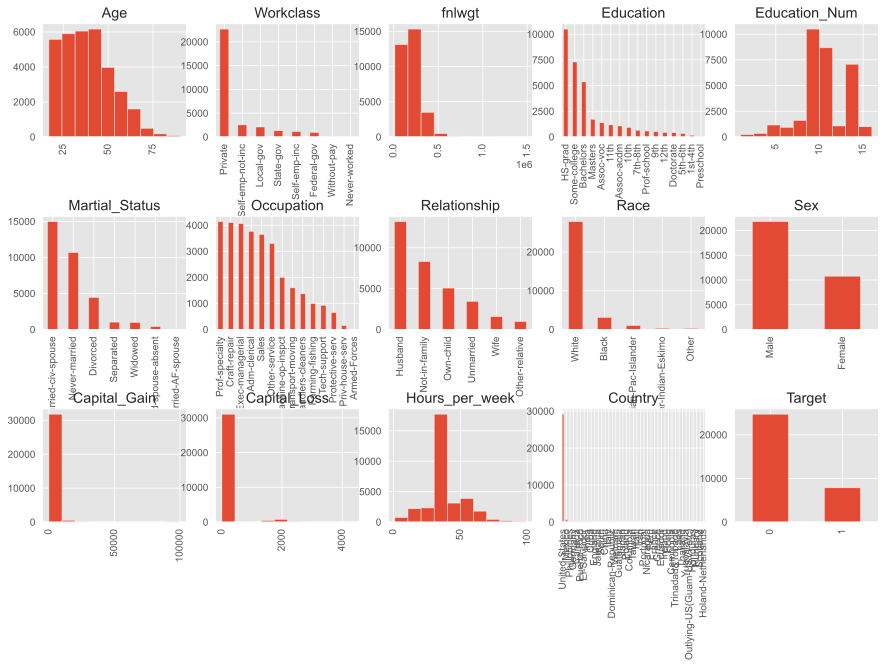

In [21]:
fig = plt.figure(figsize=(15, 9))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


Перевіряємо типи даних.

In [22]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [23]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

З'ясувалося, що в тестовому наборі даних вік віднесений до типу object, необхідно це виправити.

In [24]:
data_test['Age'] = data_test['Age'].astype(int)

Також переведемо показники типу float в int для відповідності train і test вибірок.

In [25]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

Заповнимо пропуски в кількісних полях значеннями [медіан](https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D1%96%D0%B0%D0%BD%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)), а в категоріальних - ті значення, що зустрічаються найчастіше ([мода](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0))).

In [26]:
# виділимо у вибірках категоріальні і числові поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [27]:
# заповнюємо пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

Кодуємо категоріальні ознаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Це можна зробити за допомогою методу `pandas get_dummies`.

In [28]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [29]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [30]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [31]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [32]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

У тестовій вибірці не виявилося Нідерландів. Заведемо необхідну ознаку та заповнимо рядки нулями.

In [33]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [34]:
set(data_train.columns) - set(data_test.columns)

set()

In [35]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [37]:
# Переназначимо цільову ознаку 'Target'
# як окремий список міток для навчального та тестового наборів даних
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

# Подамо навчальні та тестові дані у вигляді матриць `dtype=np.float32`
X_train = X_train.values
X_test = X_test.values

<a class="anchor" id="3.3.1"></a>

### <span style="color:blue; font-size:1em;">3.3.1. Дерево рішень без налаштування параметрів</span>

[Повернутися до змісту](#3)

Виконайте навчання дерева рішень (`DecisionTreeClassifier`) з максимальною глибиною 3 за наявною вибіркою та обрахуйте якість на тестовій вибірці. Використайте параметр `random_state` = 17 для відтворюваності результатів.

Зробіть прогноз для тестової вибірки за допомогою отриманої моделі.

<span style="color:red; font-size:2em;">Завдання 4</span>

**Для всіх варіантів:**

Яка частка правильних відповідей (accuracy) дерева рішень на тестовій вибірці за максимальної глибини дерева = 3 і random_state = 17?

**Для варіантів 1-5:**

Виконайте навчання дерева рішень з новими значеннями параметрів (max_depth=4, random_state=18) та порівняйте нове дерево із початковим (max_depth=3, random_state=17) за значенням частки правильних відповідей accuracy.

**Для варіантів 6-10:**

Виконайте навчання дерева рішень з новими значеннями параметрів (max_depth=2, random_state=16) та порівняйте нове дерево із початковим (max_depth=3, random_state=17) за значенням частки правильних відповідей accuracy.

**Для варіантів 11-15:**

Виконайте навчання дерева рішень з новими значеннями параметрів (max_depth=5, random_state=19) та порівняйте нове дерево із початковим (max_depth=3, random_state=17) за значенням частки правильних відповідей accuracy.

**Для варіантів 16-20:**

Виконайте навчання дерева рішень з новими значеннями параметрів (max_depth=5, random_state=20) та порівняйте нове дерево із початковим (max_depth=3, random_state=17) за значенням частки правильних відповідей accuracy.

<a class="anchor" id="3.3.2"></a>

### <span style="color:blue; font-size:1em;">3.3.2. Дерево рішень з налаштуванням параметрів</span>

[Повернутися до змісту](#3)

Виконайте навчання дерева рішень (`DecisionTreeClassifier`, знову `random_state` = 17) за наявною вибіркою. Параметр максимальної глибини `max_depth` встановіть у діапазоні [2; 10] та налаштуйте його на 5-кратній крос-валідації за допомогою `GridSearchCV`.

Виведіть отриманий результат за допомогою атрибутів `best_params_` та `best_score_`.

Виконайте навчання дерева рішень (`DecisionTreeClassifier`) з найкращим значенням максимальної глибини за наявною вибіркою (тобто, *Best params: {'max_depth': ##}*) та оцініть частку правильних відповідей за тстовим набором даних. Використайте параметр random_state = 17 для відтворюваності результатів.

<span style="color:red; font-size:2em;">Завдання 5</span>

**Для всіх варіантів:**

Яка частка правильних відповідей (accuracy) дерева рішень на тестовій вибірці за найкращої максимальної глибини дерева (яку Ви отримали в результаті застосування `GridSearchCV`) і random_state = 17?

**Для варіантів 1-5:**

Виконайте порівняння побудованого дерева (max_depth='Best_params', random_state=17) із деревом з параметрами (max_depth=4, random_state=18) за показником accuracy.

**Для варіантів 6-10:**

Виконайте порівняння побудованого дерева (max_depth='Best_params', random_state=17) із деревом з параметрами (max_depth=2, random_state=16) за показником accuracy.

**Для варіантів 11-15:**

Виконайте порівняння побудованого дерева (max_depth='Best_params', random_state=17) із деревом з параметрами (max_depth=5, random_state=19) за показником accuracy.

**Для варіантів 16-20:**

Виконайте порівняння побудованого дерева (max_depth='Best_params', random_state=17) із деревом з параметрами (max_depth=5, random_state=20) за показником accuracy.